<a href="https://colab.research.google.com/github/Sokratis1000/time-series-forcasting/blob/master/1990's_including_risk_factors_known_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 30.0 MB/s 
     |████████████████████████████████| 529 kB 63.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 18.5 MB/s 
     |████████████████████████████████| 308 kB 56.2 MB/s 
     |████████████████████████████████| 209 kB 60.7 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 112 kB 68.1 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 147 kB 69.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=da7e1be9011a6ce68f2af49a864b794a2cb11ca706d10b27d76b7ecf50bcb0c0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7b

In [ ]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving From_1990.csv to From_1990.csv


In [ ]:
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(data_to_load['From_1990.csv']),encoding = "ISO-8859-1")

In [ ]:
data['Date']=pd.to_datetime(data['Date'])

In [ ]:
# add time index
data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
data["time_idx"] -= data["time_idx"].min()
# add additional features
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_Construction_Employment_State"] = np.log(data.Construction_Employment_State + 1e-8)
data["avg_volume_by_state"] = data.groupby(["time_idx", "State"], observed=True).Construction_Employment_State.transform("mean")



#we want to encode special days as one variable and thus need to first reverse one-hot encoding
Extreme_Events=[
"Recession",
]
data[Extreme_Events] = data[Extreme_Events].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,State,Date,Construction_Employment_State,Coincident_Economic_Activity_State,Labor_Force_Participation_State,Permits_Housing_State,Unemployment_Rate_State,Property_Damage_State,Construction_Employment_US,PPI_Machinary_US,...,Dist_Wyoming,Risk_index,Expected_Loss_per_Capita,Annual_Expected_Losses_Millions,Greatest_Potential_Hazard,Building_Losses_Percent,time_idx,month,log_Construction_Employment_State,avg_volume_by_state
16496,Texas,2020-09-01,718.1,141.34,63.0,15261.04,7.7,0,7243,236.500,...,824.13,12.89,183.53,4615,Hurricane,0.68,368,9,6.576609,718.1
14227,Pennsylvania,1991-08-01,203.7,69.69,6.8,2606.74,6.8,5000000,4733,125.800,...,1349.71,8.79,32.49,413,Riverine Flooding,0.45,19,8,5.316648,203.7
5425,Iowa,1994-02-01,50.2,74.98,72.7,534.09,3.8,0,4923,133.400,...,505.52,10.82,204.67,623,Drought,0.35,49,2,3.916015,50.2
6576,Louisiana,1994-01-01,102.1,80.33,61.4,1114.25,7.9,0,4940,133.400,...,983.39,12.85,248.78,1128,Hurricane,0.67,48,1,4.625953,102.1
6271,Kentucky,2000-08-01,85.6,93.11,63.3,1338.13,4.2,500000,6796,148.800,...,896.20,8.65,111.74,485,Tornado,0.41,127,8,4.449685,85.6
18192,West Virginia,2002-01-01,34.5,87.08,55.9,322.60,6.1,0,6775,149.100,...,1081.34,7.33,53.90,100,Riverine Flooding,0.52,144,1,3.540959,34.5
1918,California,2021-11-01,882.0,155.93,5.8,5772.74,5.8,0,7502,258.281,...,766.89,28.10,183.07,6820,Earthquake,0.67,382,11,6.782192,882.0
13436,Ohio,2021-09-01,222.9,122.64,61.5,1541.76,4.7,0,7427,249.860,...,996.90,8.47,38.79,448,Tornado,0.61,380,9,5.406723,222.9
8894,Mississippi,1995-03-01,43.1,82.74,62.9,550.93,6.0,0,5242,136.100,...,880.88,11.56,200.85,596,Hurricane,0.61,62,3,3.763523,43.1
9839,Montana,2009-12-01,22.6,80.91,64.8,111.82,7.4,0,5654,191.200,...,322.89,6.83,89.82,89,Earthquake,0.37,239,12,3.117950,22.6


In [ ]:
data.sample(10, random_state=2)

,State,Date,Construction_Employment_State,Coincident_Economic_Activity_State,Labor_Force_Participation_State,Permits_Housing_State,Unemployment_Rate_State,Property_Damage_State,Construction_Employment_US,PPI_Machinary_US,...,Dist_Wyoming,Risk_index,Expected_Loss_per_Capita,Annual_Expected_Losses_Millions,Greatest_Potential_Hazard,Building_Losses_Percent,time_idx,month,log_Construction_Employment_State,avg_volume_by_state
4038,Hawaii,2006-07-01,12.31,98.45,66.2,370.84,2.6,500,7712,175.5,...,2922.90,18.01,117.16,159,Earthquake,0.76,198,7,2.510412,12.31
18638,Wisconsin,2007-03-01,127.90,99.54,71.0,1468.36,4.8,0,7706,178.8,...,759.75,7.34,46.88,267,Tornado,0.45,206,3,4.851249,127.90
2193,Colorado,2012-10-01,118.30,109.19,68.7,1344.28,7.6,2500000,5674,206.3,...,5692.00,7.93,96.53,485,Hail,0.70,273,10,4.773224,118.30
8991,Mississippi,2003-04-01,51.40,93.04,61.5,817.10,6.4,317000000,6689,153.3,...,880.88,11.56,200.85,596,Hurricane,0.61,159,4,3.939638,51.40
13758,Oklahoma,2016-07-01,77.90,117.30,61.1,711.90,4.8,0,6735,219.1,...,483.05,12.36,168.95,634,Tornado,0.44,318,7,4.355426,77.90
8497,Minnesota,1994-02-01,78.00,71.20,74.7,1731.98,4.4,0,4923,133.4,...,556.75,8.57,95.84,508,Drought,0.44,49,2,4.356709,78.00
1036,Arizona,2012-05-01,113.00,105.49,61.1,1478.75,8.5,270000,5604,205.1,...,577.26,23.68,47.29,302,Wildfire,0.49,268,5,4.727388,113.00
16931,Vermont,1992-12-01,11.70,66.57,71.9,167.10,6.1,0,4630,130.5,...,1399.21,5.73,39.53,25,Riverine Flooding,0.72,35,12,2.459589,11.70
18224,West Virginia,2004-09-01,34.50,91.58,55.0,396.21,5.6,117200000,7029,159.4,...,1081.34,7.33,53.90,100,Riverine Flooding,0.52,176,9,3.540959,34.50
3194,Florida,2000-03-01,479.40,78.95,67.0,8994.09,3.7,0,6811,148.3,...,1297.10,19.65,90.00,1692,Hurricane,0.65,122,3,6.172535,479.40


In [ ]:

max_prediction_length = 6
max_encoder_length = 24
#min_prediction_idx=300
training_cutoff = data["time_idx"].max() - max_prediction_length
validation_start=data["time_idx"].max() - max_prediction_length - max_encoder_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Construction_Employment_State",
    group_ids=["State"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["State"],
    static_reals=["Dist_Alabama","Dist_Alaska","Dist_Arkansas","Dist_California","Dist_Colorado","Dist_Connecticut","Dist_Delaware","Dist_Florida","Dist_Georgia","Dist_Hawaii","Dist_Idaho","Dist_Illinois","Dist_Indiana","Dist_Kansas","Dist_Kentucky","Dist_Louisiana","Dist_Maine","Dist_Maryland","Dist_Massachusetts","Dist_Michigan","Dist_Minnesota","Dist_Mississippi","Dist_Missouri","Dist_Montana","Dist_Nebraska","Dist_NewHampshire","Dist_Nevada","Dist_NewJersey","Dist_NewMexico","Dist_New York","Dist_NorthCarolina","Dist_NorthDakota","Dist_Ohio","Dist_Oklahoma","Dist_Oregon","Dist_Pennsylvania","Dist_RhodeIsland","Dist_SouthCarolina","Dist_SouthDakota","Dist_Tennessee","Dist_Texas","Dist_Utah","Dist_Vermont","Dist_Virginia","Dist_Washington","Dist_WestVirginia","Dist_Wisconsin","Dist_Wyoming"],
    #min_prediction_idx=min_prediction_idx,
    time_varying_known_categoricals=["month","Extreme_Events"],
    time_varying_known_reals=["time_idx","BCI_US"],
    #time_varying_unknown_categoricals=["Extreme_Events"],
    variable_groups={"Extreme_Events": Extreme_Events},  # group of categorical variables can be treated as one variable
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Construction_Employment_State","Coincident_Economic_Activity_State",
        "Labor_Force_Participation_State",
        "Permits_Housing_State",
        "Unemployment_Rate_State",
        "Property_Damage_State",
        "Construction_Employment_US",
        "PPI_Machinary_US",
        "PPI_Material_US",
        "CPI_US",
        "Labor_Force_Participation_US",
        "FFER_US",
        "New_Privately_Owned_Houses_US",
        "Unemployment_Rate_US",
        "Hourly_Earning_US",
        "CCI_US",
        "BCI_US",
        "MPI_US",
        "Construction_Spending_Total_US",
        "Construction_Spending_Private_US",
        "Construction_Spending_Public_US",
        "Total_Tax_Recipt",
        "Ind_Income_Tax",
        "Corporate_Tax",
        "Wages_Tax",
        "Income_Security",
    ],

    target_normalizer=GroupNormalizer(
        groups=["State"],transformation="softplus"
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x:x.time_idx > validation_start], predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
print(type(val_dataloader))



<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


1.8803339004516602

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determi

Number of parameters in network: 73.1k


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d48cec1c-808b-4717-81a2-2ea28e7f1f3e.ckpt


suggested learning rate: 0.0002818382931264453


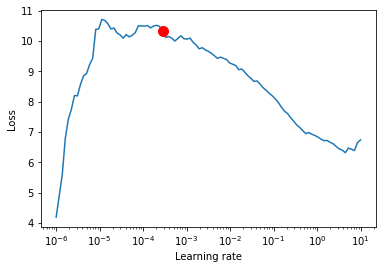

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=5.888436553555889e-06, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=1000,
    gpus=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 73.4k


In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# can be stopped at any point -- did at 24 epochs
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 788   
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 36.0 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidde

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
import pickle

In [ ]:




# can cancel, but wait after clicking -- take time to cancel
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100, #200,
    max_epochs=10,#50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
[I 2022-10-22 02:37:08,393] A new study created in memory with name: no-name-cd2ab9ae-56f9-44ce-9388-c4539352b416
[W 2022-10-22 02:37:08,399] Trial 0 fai

TypeError: ignored

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1.9048)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

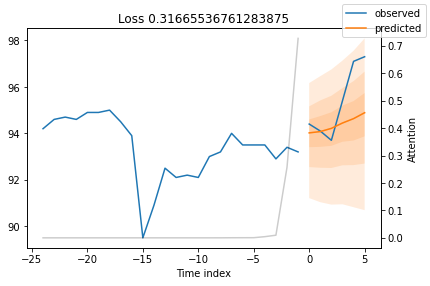

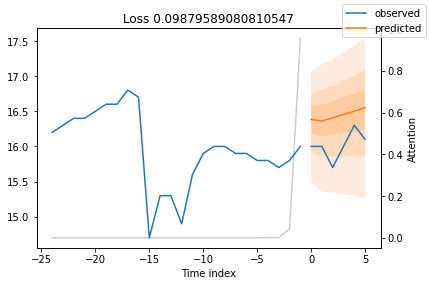

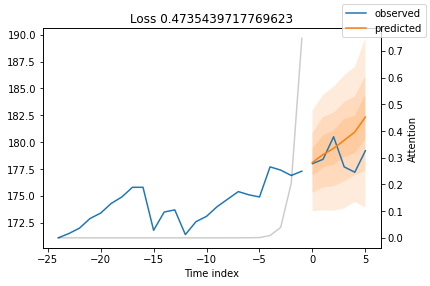

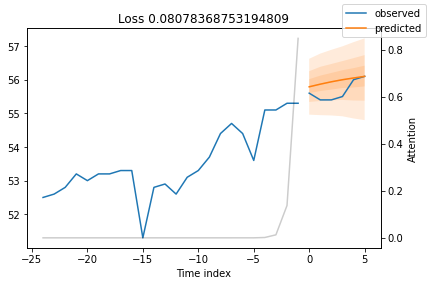

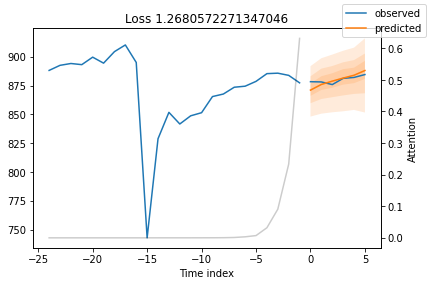

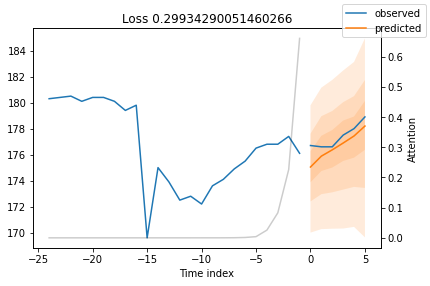

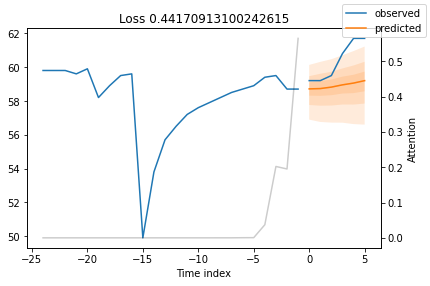

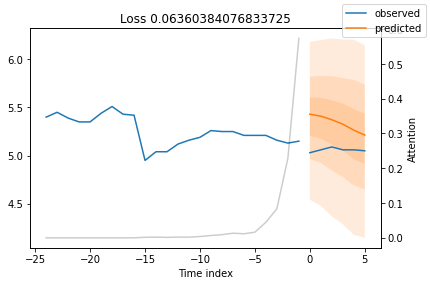

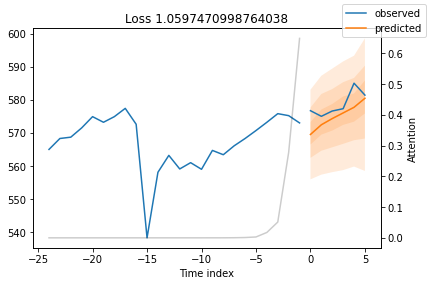

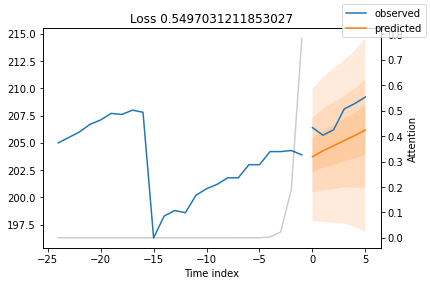

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full

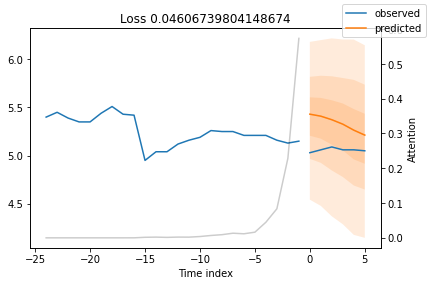

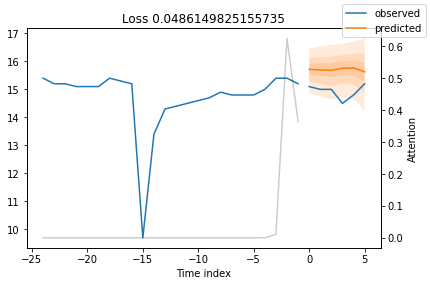

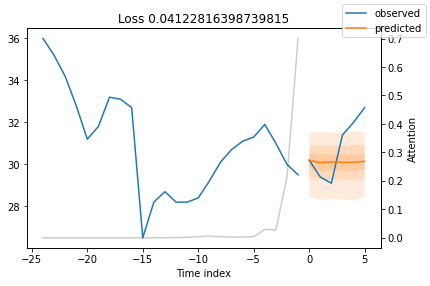

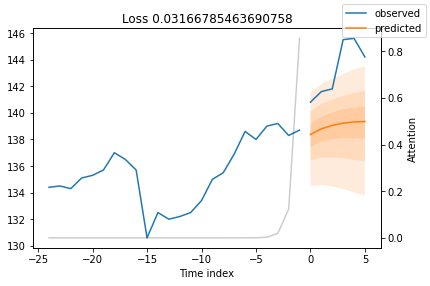

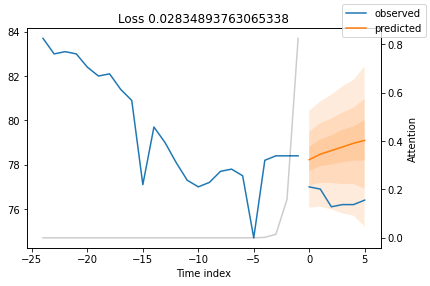

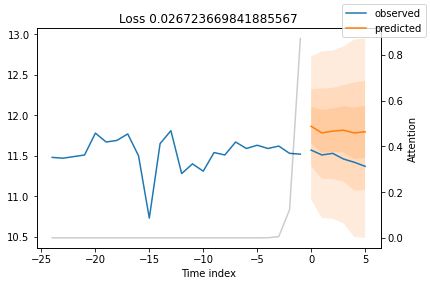

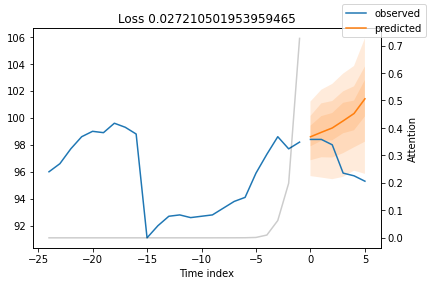

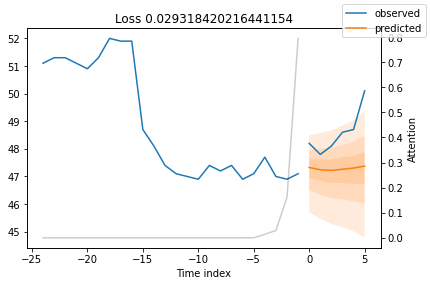

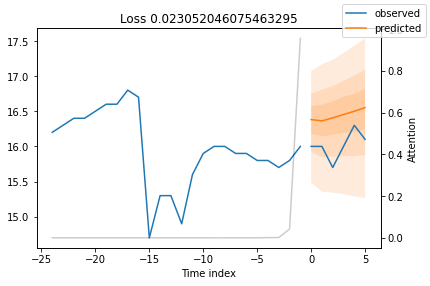

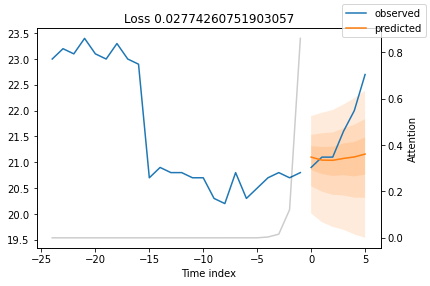

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.State == "Texas") & (x.time_idx_first_prediction == 324)),
    mode="quantiles",
)

tensor([[[673.2138, 691.3816, 697.3051, 705.9037, 711.9565, 719.7917, 733.2472],
         [672.9518, 692.5351, 699.6063, 709.1423, 715.6978, 724.0117, 737.2085],
         [676.7163, 695.5619, 703.2406, 712.2878, 719.1495, 728.1096, 739.6890],
         [677.9964, 696.9797, 704.9904, 714.1261, 721.0065, 730.3511, 741.7130],
         [674.1663, 695.4031, 704.6518, 714.6977, 722.1547, 732.0398, 744.5291],
         [678.0047, 697.6454, 706.5599, 716.8262, 724.1141, 733.5342, 745.3218]]])

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


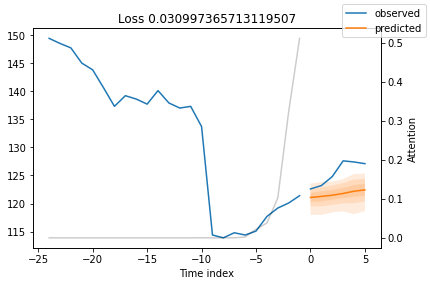

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.State == "Louisiana") & (x.time_idx_first_prediction == 372)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0,add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles));

**Importance Overall and City specific**

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x1080 with 1 Axes>,
 'encoder_variables': <Figure size 504x684 with 1 Axes>,
 'decoder_variables': <Figure size 504x216 with 1 Axes>}

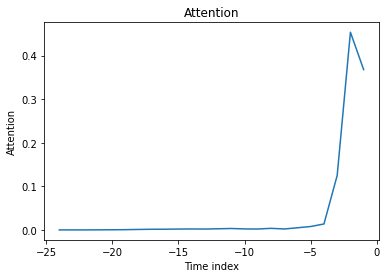

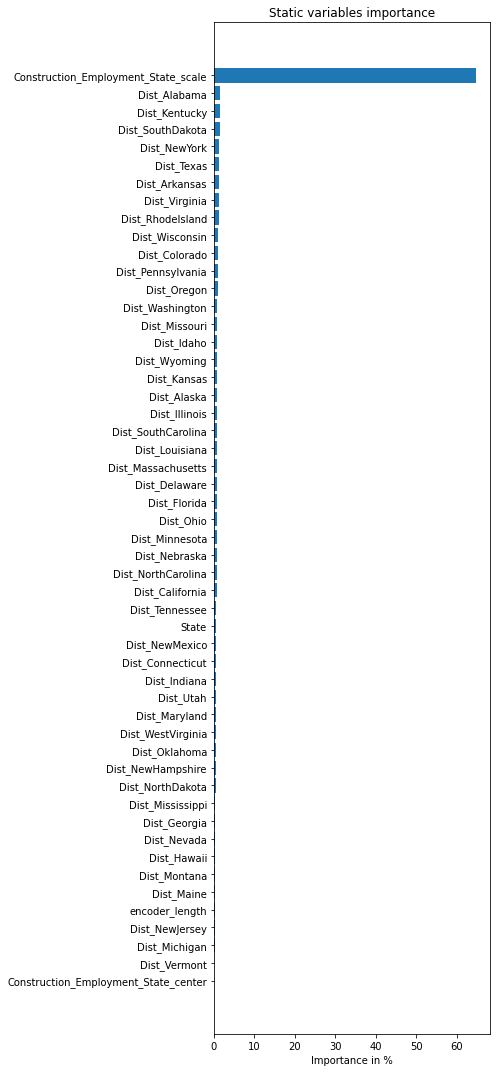

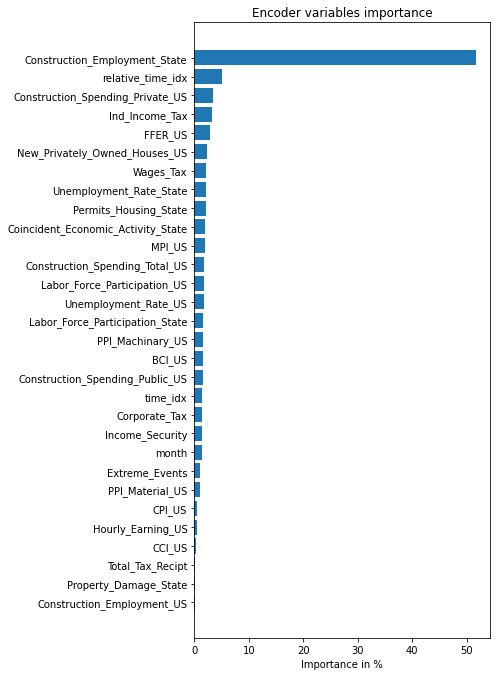

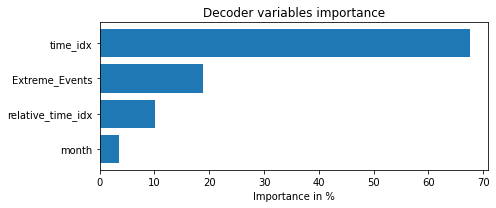

In [ ]:
interpretation = best_tft.interpret_output(raw_prediction, reduction="sum")
best_tft.plot_interpretation(interpretation)

Predict on new data


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

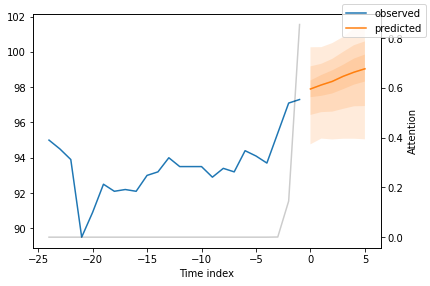

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);